In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
import plotly.express as px
from dotenv import load_dotenv
import json
from collections import defaultdict
import importlib
import warnings
warnings.filterwarnings('ignore')
import utils
importlib.reload(utils)
import os
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from scipy.optimize import differential_evolution, curve_fit
from scipy.stats import skewnorm, norm

In [3]:
def load_weather(weather_path, obs_year):    
    # Load the "Hourly" weather data
    
    weather_data = pd.read_csv(weather_path)
    # Slicing the weather data to the dates within the observation year
    weather_data['Date'] = pd.to_datetime(weather_data['Date'], errors='coerce')
    weather_data = weather_data[
        (weather_data['Date'] >= pd.to_datetime(f'1/1/{obs_year}')) &
        (weather_data['Date'] <= pd.to_datetime(f'31/12/{obs_year}'))]     
    # Renaming the columns and add doy column         
    weather_data = weather_data[['Date', 'Time', 'Air Temp. (°C)']].rename(columns={'Date': 'date', 'Time':'Time', 'Air Temp. (°C)':'temp'}, inplace=False)
    weather_data.insert(1, 'doy', [d.dayofyear for d in pd.to_datetime(weather_data['date'], format="mixed")])
    # Interpolate missing values
    # Convert '-' to NaN
    weather_data['temp'].replace('-', np.nan, inplace=True)
    weather_data['temp']=weather_data['temp'].apply(pd.to_numeric, errors='coerce')

    # Interpolate missing values
    if weather_data['temp'].isna().any():
        weather_data['temp'].interpolate(method='linear', inplace=True)


    return weather_data.reset_index(drop=True) 


In [4]:
# Load datasets for observations
def load_observations_HC(file_path,BB_sheet_name, Flwr_sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location, excel_observs_BB, excel_observs_Flwr, spray_col_name):
    
    # Define the expected column names for the final concatenated DataFrame
    TREATMENT = "Treatment"
    LOCATION = "Location"
    xls = pd.ExcelFile(file_path, engine="openpyxl")
    raw_df_BB = pd.read_excel(xls, sheet_name = BB_sheet_name)
    raw_df_Flwr = pd.read_excel(xls, sheet_name = Flwr_sheet_name)

    # Rename the Dates to Days of Year (DOY)
    doy_column_BB = [pd.to_datetime(col).dayofyear for col in raw_df_BB.columns if utils.is_date_column(col)]
    df_BB = raw_df_BB.rename(columns={col:pd.to_datetime(col).dayofyear for col in raw_df_BB.columns if utils.is_date_column(col)})

    doy_column_Flwr = [pd.to_datetime(col).dayofyear for col in raw_df_Flwr.columns if utils.is_date_column(col)]
    df_Flwr = raw_df_Flwr.rename(columns={col:pd.to_datetime(col).dayofyear for col in raw_df_Flwr.columns if utils.is_date_column(col)})

    obs_year = [pd.to_datetime(col).year for col in raw_df_BB.columns if utils.is_date_column(col)][0]


    # Apply filtering for the given cultivar & treatments
    def filter_df(df, doy_column, spray_col_name):
        filtered_df = df[df[cultivar_col].isin([cultivar_name]) & df[treatment_col].isin([treatment_name])]
        # Rename columns
        columns_to_select = [treatment_col] + [spray_col_name] + doy_column 
        filtered_df = filtered_df[columns_to_select]
        filtered_df.rename(columns={treatment_col: TREATMENT}, inplace=True)
        # Add the LOCATION column to the DataFrame
        filtered_df[LOCATION] = location
        # Remove rows with any NaN values
        filtered_df = filtered_df.dropna()
        # Reset index 
        filtered_df.reset_index(drop=True)
        return filtered_df
    filtered_df_BB = filter_df(df_BB,doy_column_BB, spray_col_name)

    filtered_df_Flwr = filter_df(df_Flwr,doy_column_Flwr, spray_col_name)

    # Spray date(s)
    application_dates = filtered_df_BB[spray_col_name].unique()

    BudBurstDOYs = []
    FlwrDOYs = []
    for spray_date in application_dates:
        # find the budburst doy for each application date
        filtered_df_BB_spray = filtered_df_BB[filtered_df_BB[spray_col_name].isin([spray_date])]
        BB_percent = False
        PBB, BB, BudBurstDOY, max_observed_buds = utils.BB_specifications(location,filtered_df_BB_spray[doy_column_BB],BB_percent)
        BudBurstDOYs.append(int(BudBurstDOY))
        maxBBPsequence = np.empty(len(doy_column_BB))*np.nan
        maxBBPsequence[-1] = np.max(PBB)

        # Corresponding stage name (StartFlowering) to get the max BBP 
        MaxBBPstageSequence = [np.nan for i in range(len(doy_column_BB))]
        MaxBBPstageSequence[-1] = 'StartFlowering'


        # Generate the observations Excel file for Budbreak
        excel_observ_BB = pd.DataFrame(data={
        'SimulationName': f'{BB_sheet_name}{filtered_df_BB_spray[TREATMENT].iloc[0].replace(" ", "")}{pd.to_datetime(spray_date).day_of_year}', 
                                            'Clock.Today': [col for col in raw_df_BB.columns if utils.is_date_column(col)],
                                            'Clock.Today.Year': obs_year,
                                            'DOY': doy_column_BB, 
                                            LOCATION: filtered_df_BB_spray[LOCATION].iloc[0], 
                                            TREATMENT: filtered_df_BB_spray[TREATMENT].iloc[0],
                                            'KiwiFruit.Phenology.BrokenBuds': BB,
                                            'KiwiFruit.Phenology.ProportionBB': PBB,
                                            'KiwiFruit.Phenology.BudBurstDOY': BudBurstDOY,
                                            'KiwiFruit.Phenology.MaxBBP': maxBBPsequence,
                                            'KiwiFruit.Phenology.CurrentStageName': MaxBBPstageSequence})
        
        FlwrDOY, Flowers = utils.Flwr_specifications(np.max(BB),filtered_df_Flwr[doy_column_Flwr])
        FlwrDOYs.append(int(FlwrDOY))
        maxFlwrsequence = np.empty(len(doy_column_Flwr))*np.nan
        maxFlwrsequence[-1] = FlwrDOY

        # Corresponding stage name (StartFlowering) to get the max BBP 
        MaxFlwrstageSequence = [np.nan for i in range(len(doy_column_Flwr))]
        MaxFlwrstageSequence[-1] = 'StartFlowering'

        # Generate the observations Excel file for Flowering
        excel_observ_Flwr = pd.DataFrame(data={
        'SimulationName': f'{BB_sheet_name}{filtered_df_BB[TREATMENT].iloc[0].replace(" ", "")}{pd.to_datetime(spray_date).day_of_year}',  # Use same BB sheet name to be able to put in same apsim simulation
                                            'Clock.Today': [col for col in raw_df_Flwr.columns if utils.is_date_column(col)],
                                            'Clock.Today.Year': obs_year,
                                            'DOY': doy_column_Flwr, 
                                            LOCATION: filtered_df_Flwr[LOCATION].iloc[0], 
                                            TREATMENT: filtered_df_Flwr[TREATMENT].iloc[0],
                                            'KiwiFruit.Phenology.Flowers': Flowers,
                                            'KiwiFruit.Phenology.FloweringDOY': FlwrDOY,
                                            'KiwiFruit.Phenology.CurrentStageName': MaxFlwrstageSequence})
        
        excel_observs_BB.append(excel_observ_BB)
        excel_observs_Flwr.append(excel_observ_Flwr)

    return obs_year, application_dates, PBB, BB, BudBurstDOYs, FlwrDOYs, excel_observs_BB, excel_observs_Flwr
    


In [5]:
# Load datasets for observations
def load_observations_control(file_path,BB_sheet_name, Flwr_sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location):
    
    # Define the expected column names for the final concatenated DataFrame
    TREATMENT = "Treatment"
    LOCATION = "Location"
    xls = pd.ExcelFile(file_path, engine="openpyxl")
    raw_df_BB = pd.read_excel(xls, sheet_name = BB_sheet_name)
    raw_df_Flwr = pd.read_excel(xls, sheet_name = Flwr_sheet_name)

    # Rename the Dates to Days of Year (DOY)
    doy_column_BB = [pd.to_datetime(col).dayofyear for col in raw_df_BB.columns if utils.is_date_column(col)]
    df_BB = raw_df_BB.rename(columns={col:pd.to_datetime(col).dayofyear for col in raw_df_BB.columns if utils.is_date_column(col)})

    doy_column_Flwr = [pd.to_datetime(col).dayofyear for col in raw_df_Flwr.columns if utils.is_date_column(col)]
    df_Flwr = raw_df_Flwr.rename(columns={col:pd.to_datetime(col).dayofyear for col in raw_df_Flwr.columns if utils.is_date_column(col)})

    obs_year = [pd.to_datetime(col).year for col in raw_df_BB.columns if utils.is_date_column(col)][0]


    # Apply filtering for the given cultivar & treatments
    def filter_df(df, doy_column):
        filtered_df = df[df[cultivar_col].isin([cultivar_name]) & df[treatment_col].isin([treatment_name])]
        # Rename columns
        columns_to_select = [treatment_col] + doy_column 
        filtered_df = filtered_df[columns_to_select]
        filtered_df.rename(columns={treatment_col: TREATMENT}, inplace=True)
        # Add the LOCATION column to the DataFrame
        filtered_df[LOCATION] = location
        # Remove rows with any NaN values
        filtered_df = filtered_df.dropna()
        # Reset index 
        filtered_df.reset_index(drop=True)
        return filtered_df
    filtered_df_BB = filter_df(df_BB,doy_column_BB)
    filtered_df_Flwr = filter_df(df_Flwr,doy_column_Flwr)


    # find the budburst doy for control treatments
    BB_percent = False
    PBB, BB, BudBurstDOY, max_observed_buds = utils.BB_specifications(location,filtered_df_BB[doy_column_BB],BB_percent)

    FlwrDOY, Flowers = utils.Flwr_specifications(np.max(BB),filtered_df_Flwr[doy_column_Flwr])


    return obs_year, PBB, BB, BudBurstDOY, FlwrDOY
    


In [6]:
with open("config_MultiDataFiles_HC.json", "r") as file:
    config = json.load(file)
base_model_config = utils.base_model_config()
start_doy = pd.to_datetime(base_model_config["StartDay"]).dayofyear

predicted_endo_release_doy = defaultdict(lambda: defaultdict(lambda: dict()))
predicted_budbreak_doy = defaultdict(lambda: defaultdict(lambda: dict()))
observed_budbreak_doy = defaultdict(lambda: defaultdict(lambda: dict()))
predicted_flowering_doy = defaultdict(lambda: defaultdict(lambda: dict()))
observed_flowering_doy = defaultdict(lambda: defaultdict(lambda: dict()))
observed_application_doy = defaultdict(lambda: defaultdict(lambda: dict()))
observed_budbreak_doy_control = defaultdict(lambda: defaultdict(lambda: dict()))
weather_df = defaultdict(lambda: defaultdict(lambda: dict()))
excel_observs_BB = []
excel_observs_Flwr = []
output_excel = 'HC_Observations.xlsx'

# Load environment variables
load_dotenv()
FOLDER_PATH = os.getenv('FOLDER_PATH')
for file_name, file_info in config.items():
        file_path = os.path.join(FOLDER_PATH, file_name)
        # Process each sheet
        for sheet_info in file_info['sheets']:
            # Extract sheet names, cultivars, and treatments
            BB_sheet_name = sheet_info['BB_sheet_name']
            Flwr_sheet_name = sheet_info['Flwr_sheet_name']
            location = sheet_info['location']
            spray_col_name = sheet_info['spray']
            control_col, control_name  = list(sheet_info['control'].items())[0]
            cultivar_col, cultivar_name = list(sheet_info['cultivar'].items())[0]
            treatment_col, treatment_name = list(sheet_info['treatments'].items())[0]

            # Load and calculate the observed budburst doy
            obs_year, application_dates, PBB, BB, BudBurstDOYs, Flwr_DOYs, excel_observs_BB, excel_observs_Flwr = load_observations_HC(file_path,BB_sheet_name, Flwr_sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location,excel_observs_BB, excel_observs_Flwr,spray_col_name)
            obs_year, PBB_control, BB_control, BudBurstDOY_control, FlwrDOY_control = load_observations_control(file_path,BB_sheet_name, Flwr_sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location)

            for spray_date,BudBurstDOY,Flwr_DOY in zip(application_dates,BudBurstDOYs,Flwr_DOYs):
                observed_budbreak_doy[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = BudBurstDOY
                observed_flowering_doy[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = Flwr_DOY
                observed_application_doy[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = pd.to_datetime(spray_date).dayofyear

                # Load and store the weather data
                weather_path = sheet_info['weather_path']
                weather_data = load_weather(weather_path, obs_year)
                weather_df[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = weather_data

                # Add the control values for BB doy
                observed_budbreak_doy_control[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = BudBurstDOY_control




excel_observs_BB_df = pd.concat(excel_observs_BB, ignore_index=True, sort=False)
excel_observs_Flwr_df = pd.concat(excel_observs_Flwr, ignore_index=True, sort=False)

with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
    excel_observs_BB_df.to_excel(writer, sheet_name='BB-HC', index=False)
    excel_observs_Flwr_df.to_excel(writer, sheet_name='Flwr-HC', index=False)

In [7]:
def Chill(Tc, T):
    if T>=0 and T <= Tc:
        return (((4*T)/(Tc**2))*(Tc-T))
    else:
        return 0
    
def Wangengel(MinTemp,OptTemp,MaxTemp,RefTemp,T):
    RelEff = 0.0
    RelEffRefTemp = 1.0
    p = 0.0

    if MinTemp < T < MaxTemp:
        p = math.log(2.0) / math.log((MaxTemp - MinTemp) / (OptTemp - MinTemp))
        RelEff = (2 * (T - MinTemp) ** p * (OptTemp - MinTemp) ** p - (T - MinTemp) ** (2 * p)) / (OptTemp - MinTemp) ** (2 * p)

    if MinTemp < RefTemp < MaxTemp:
        p = math.log(2.0) / math.log((MaxTemp - MinTemp) / (OptTemp - MinTemp))
        RelEffRefTemp = (2 * (RefTemp - MinTemp) ** p * (OptTemp - MinTemp) ** p - (RefTemp - MinTemp) ** (2 * p)) / (OptTemp - MinTemp) ** (2 * p)

    return float(RelEff / RelEffRefTemp)

# Budbreak prediction 
def budbreak_prediction(weather_since_start_doy, chill_target, heat_target):
    chillVal = 0
    for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
        chillVal += Chill( base_model_config['Tc_chill'], temp)
        if chillVal >= chill_target:
            break

    # Heat accumulation
    # from the date of endodormancy release, start accumulating heat
    heatVal = 0
    for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
        heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)
        if heatVal >= heat_target:
            predicted_doy = int(weather_since_start_doy['doy'].iloc[idx_endodormancy_release + idx_bb + 1])
            break
    return predicted_doy

def logistic_scaling(app_units, ideal_units,max_effect_low, max_effect_high, steepness):
    distance = app_units - ideal_units
    scale = 1 / (1 + np.exp(-steepness * distance))
    max_effect = max_effect_low + scale * (max_effect_high - max_effect_low)
    return max_effect

def linear_scaling(app_units, ideal_units, max_effect_high, max_effect_low,  tolerance):
    # Linear scaling of max_effect depending on distance from ideal_doy
    distance = abs(app_units - ideal_units)
    scale = min(distance / tolerance, 1)  # cap at 1 to avoid over-scaling
    max_effect = max_effect_low + scale * (max_effect_high - max_effect_low)
    return max_effect

def quadratic_scaling(app_units, ideal_units, max_effect_high, max_effect_low,  tolerance):
    # Linear scaling of max_effect depending on distance from ideal_doy
    distance = abs(app_units - ideal_units)
    scale = min(distance / tolerance, 1) ** 2 # cap at 1 to avoid over-scaling
    max_effect = max_effect_low + scale * (max_effect_high - max_effect_low)
    return max_effect

def hi_cane_effective_chill_target(ideal_units, max_effect, tolerance, app_units, base_chill_target):
    """
    Adjusts effective chill target based on timing of Hi-Cane application and 
    a linearly scaled max effect that varies with application units (app_units) relative to ideal window.
    
    Parameters:
    - ideal_units: target accumulated units where Hi-Cane is most effective
    - max_effect_high: effect when applied far from ideal (e.g. early/late)
    - max_effect_low: effect when applied near the ideal time
    - tolerance: spread of the Gaussian curve
    - app_units: accumulated chill units at application
    - base_chill_target: baseline chill requirement without Hi-Cane
        
    Returns:
        adjusted chill target based on application timing
    """
    Gaussian = max_effect * np.exp(-0.5 * ((app_units - ideal_units) / tolerance) ** 2)

    # linear scaling:
    # max_effect = quadratic_scaling(app_units, ideal_units, max_effect_high, max_effect_low, tolerance)

    effect = 1 - Gaussian

    effective_chill_target = base_chill_target * effect

    return effective_chill_target

def logistic(app_units, ideal_units, max_effect, steepness, elevation):
    return elevation + max_effect/(1 + np.exp(-steepness*(app_units - ideal_units)))

def skewed_gaussian_effect(Acc_unit_spray, max_effect, center, width, skew, base_chill_target):
    skewed_Guassian =  skewnorm.pdf(Acc_unit_spray - center, a=skew, scale=width) 
    effect = 1 - max_effect * skewed_Guassian
    effective_chill_target = base_chill_target * effect

    return effective_chill_target


# Calculate Acc. Chill & Heat units on Spray Date

In [8]:
CU_spray = defaultdict(lambda: defaultdict(lambda: dict()))
HU_spray = defaultdict(lambda: defaultdict(lambda: dict()))
CHU_spray = defaultdict(lambda: defaultdict(lambda: dict()))


CHU_observation = defaultdict(lambda: defaultdict(lambda: dict()))
CU_observation = defaultdict(lambda: defaultdict(lambda: dict()))
HU_observation = defaultdict(lambda: defaultdict(lambda: dict()))


start_day = int(round(pd.to_datetime(utils.base_model_config()['StartDay']).day_of_year))

for location in observed_application_doy.keys():
    for year in observed_application_doy[location].keys():
        for sheet_info, weather_data in weather_df[location][year].items():
            application_doy = observed_application_doy[location][year][sheet_info]
            observation_doy = observed_budbreak_doy[location][year][sheet_info]
            weather_since_start_doy = weather_data[weather_data['doy']>=start_day].reset_index(drop=True)  
            
            # Chill & heat accumulation on Spray Date
            chillVal = 0
            heatVal = 0
            for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
                chillVal += Chill( base_model_config['Tc_chill'], temp)
                if (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] == application_doy and chillVal < base_model_config['ChillRequirement']):
                    CHU_spray[location][year][sheet_info] = chillVal    
                    CU_spray[location][year][sheet_info] = chillVal   # store accumulated chill in a separate dict
                    break 
                elif (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] < application_doy and chillVal >= base_model_config['ChillRequirement']):
                    CU_spray[location][year][sheet_info] = base_model_config['ChillRequirement']   # store accumulated chill in a separate dict
                    break 
            for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
                heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)                       
                if weather_since_start_doy['doy'].iloc[idx_bb+idx_endodormancy_release+1] == application_doy: # count all the heat units even if it's over the heat target (to account for even after BB spraying)                       
                    CHU_spray[location][year][sheet_info] = chillVal + heatVal
                    HU_spray[location][year][sheet_info] = heatVal   # store accumulated heat in a separate dict
                    break 

            # Chill & heat accumulation on Observation Date
            chillVal = 0
            heatVal = 0
            for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
                    chillVal += Chill( base_model_config['Tc_chill'], temp)
                    if (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] == observation_doy and chillVal < base_model_config['ChillRequirement']):
                        CHU_observation[location][year][sheet_info] = chillVal    
                        CU_observation[location][year][sheet_info] = chillVal   # store accumulated chill in a separate dict
                        break 
                    elif (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] < observation_doy and chillVal >= base_model_config['ChillRequirement']):
                        CU_observation[location][year][sheet_info] = base_model_config['ChillRequirement'] # store accumulated chill in a separate dict
                        break 
            # if (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] < observation_doy and chillVal >= base_model_config['ChillRequirement']):
            for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
                heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)                       
                if weather_since_start_doy['doy'].iloc[idx_bb+idx_endodormancy_release+1] == observation_doy: # count all the heat units even if it's over the heat target (to account for even after BB spraying)                       
                    CHU_observation[location][year][sheet_info] = chillVal + heatVal
                    HU_observation[location][year][sheet_info] = heatVal  # store accumulated heat in a separate dict
                    break 
                     

In [23]:
# Print the experiment names that HC was applied during endodormancy (acc. heat at spraying time is zero) and
# the acc. heat at observed budbreak time does not exceed the Heat Requirement (101.29 units)
i = 0
heat_acc_threshold = 0.02
for loc in HU_spray.keys():
    for year in HU_spray[loc].keys():
            for sheet_info in HU_spray[loc][year]:
                if HU_spray[loc][year][sheet_info] < heat_acc_threshold and HU_observation[loc][year][sheet_info] < base_model_config['HeatRequirement']:
                    print(sheet_info, round(CU_spray[loc][year][sheet_info],2), HU_spray[loc][year][sheet_info])
                    i += 1
print(i)

HW-BudbreakTP2020HiCane223 1642.93 0.00037124632696152593
HW-Budbreak-TP2020HiCane226 1688.61 0.0009611741321809171
HWBBRawTP2021HiCane214 1383.57 0.003992192746978747
HWBBRawTP2021HiCane223 1532.14 4.4832643331235084e-06
HWBBRawTP2021HiCane232 1666.2 9.301144557089224e-05
NBB2010HC236 1446.09 0.0024798576114859225
NBB2011HC248 1484.91 7.202690844160844e-05
KKHaywardBB2013HC239 1533.29 0.005099222383619593
KKHaywardBB2018HiCane 6% + 0.2% Driftstop239 1452.06 0.00011860055386929313
KKHaywardBB2018HiCane 6% + 0.2% Driftstop248 1553.68 0.00027309213181635444
HaywardBB2019HC 6% + 0.2%DS236 1472.81 0.018017415105686514
HaywardBB2019HC 6% + 0.2%DS243 1561.79 6.320298494939304e-07
HWBBRaw2020HiCane+Driftstop240 1346.11 5.89184178433483e-05
HWBBRaw2020HiCane+Driftstop235 1297.61 0.013258201892383203
HWBBRaw2020HiCane+Driftstop247 1428.57 3.219152502436261e-07
HWBBSpray2020HiCane+Driftstop248 1444.12 4.79605339591688e-09
HWBBSpray2020HiCane+Driftstop243 1387.19 0.000737276959492689
17


# Calculate Acc. Chill units on Control BB Date

In [24]:
CHU_observation_control = defaultdict(lambda: defaultdict(lambda: dict()))

start_day = int(round(pd.to_datetime(utils.base_model_config()['StartDay']).day_of_year))

for location in observed_budbreak_doy_control.keys():
    for year in observed_budbreak_doy_control[location].keys():
        for sheet_info, weather_data in weather_df[location][year].items():
            application_doy = observed_budbreak_doy_control[location][year][sheet_info]
            observation_doy = observed_budbreak_doy_control[location][year][sheet_info]
            weather_since_start_doy = weather_data[weather_data['doy']>=start_day].reset_index(drop=True)  

            # Chill & heat accumulation on Observation Date
            chillVal = 0
            heatVal = 0
            for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
                    chillVal += Chill( base_model_config['Tc_chill'], temp)
                    if (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] == observation_doy and chillVal < base_model_config['ChillRequirement']):
                        CHU_observation_control[location][year][sheet_info] = chillVal    
                        break 
                    elif (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] < observation_doy and chillVal >= base_model_config['ChillRequirement']):
                        break 
            # if (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] < observation_doy and chillVal >= base_model_config['ChillRequirement']):
            for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
                heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)                       
                if weather_since_start_doy['doy'].iloc[idx_bb+idx_endodormancy_release+1] == observation_doy: # count all the heat units even if it's over the heat target (to account for even after BB spraying)                       
                    CHU_observation_control[location][year][sheet_info] = chillVal + heatVal
                    break 


In [25]:
observations = []
predictions = []
spray_doys = []
chu_obs = []
chu_spray = []
control = []
cu_obs = []
cu_spray = []
hu_obs = []
hu_spray = []

hc_doy = []
control_doy = []

for loc in observed_budbreak_doy.keys():
     for year in observed_budbreak_doy[loc].keys():
            for sheet_info in observed_budbreak_doy[loc][year]:
                observed_bb = observed_budbreak_doy[loc][year][sheet_info]
                observations.append(observed_bb)
                # predicted_bb = predicted_budbreak_doy[loc][year][sheet_info]
                # predictions.append(predicted_bb)

                spray_doys.append(observed_application_doy[loc][year][sheet_info])
                chu_obs.append(CHU_observation[loc][year][sheet_info])
                chu_spray.append(CHU_spray[loc][year][sheet_info])
                control.append(CHU_observation_control[loc][year][sheet_info])

                control_doy.append(observed_budbreak_doy_control[loc][year][sheet_info])
                hc_doy.append(observed_budbreak_doy[loc][year][sheet_info])

                # Having the acc. chill & heat units separately at observed BB and HC spray time
                cu_obs.append(CU_observation[loc][year][sheet_info])
                hu_obs.append(HU_observation[loc][year][sheet_info])
                cu_spray.append(CU_spray[loc][year][sheet_info])
                hu_spray.append(HU_spray[loc][year][sheet_info])


# Hi-Cane Effectiveness on Chill Target

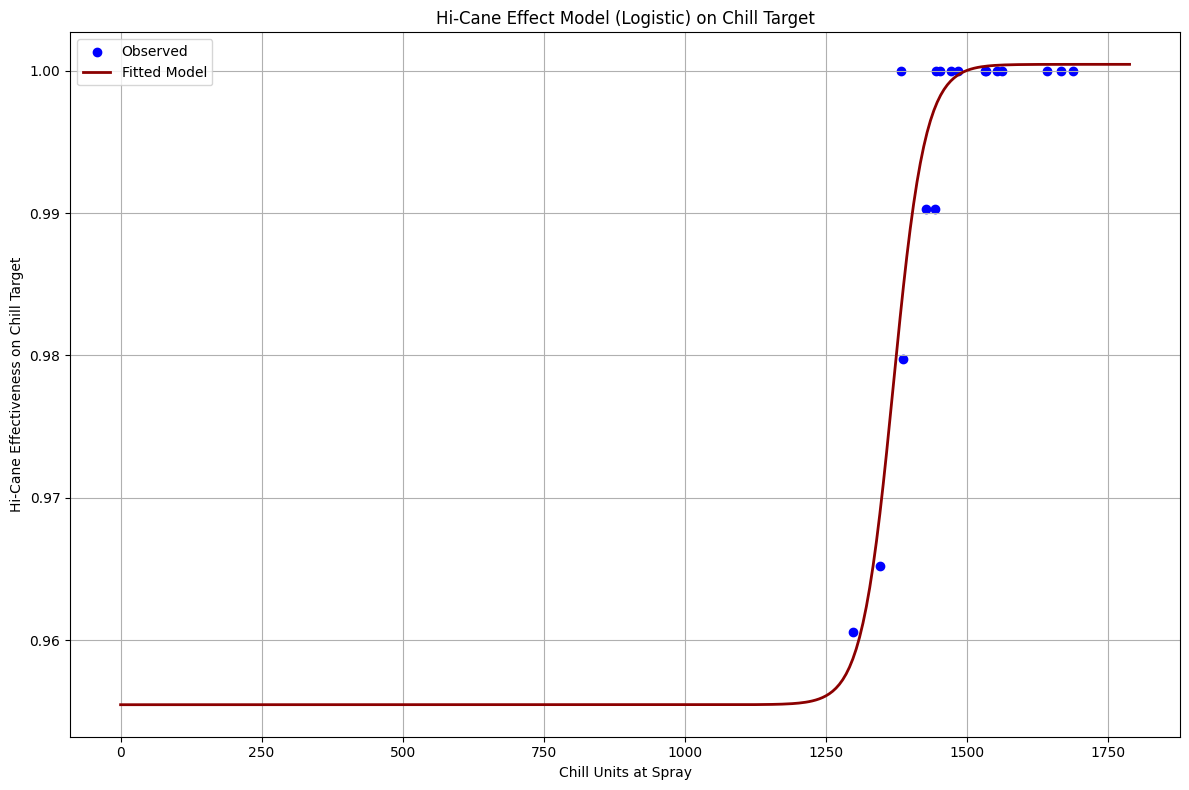

mu: 1370.000
A: 0.045
k: 0.036
e: 0.955


In [26]:
chill_requirement = base_model_config['ChillRequirement']
heat_requirement = base_model_config['HeatRequirement']


chu_spray = np.array(chu_spray)
chu_obs = np.array(chu_obs)
control = np.array(control)
spray_doys = np.array(spray_doys)

control_doy = np.array(control_doy)
hc_doy = np.array(hc_doy)

cu_spray = np.array(cu_spray)
cu_obs = np.array(cu_obs)
hu_spray = np.array(hu_spray)
hu_obs = np.array(hu_obs)

filter_endo_spray = (hu_spray < heat_acc_threshold) & (hu_obs <= heat_requirement)

x = cu_spray[filter_endo_spray]
y = cu_obs[filter_endo_spray]/chill_requirement

# Initial guess: [mu, A, k, e]
p0 = [1400, 0.045, 0.5, 0.9]

# Parameter bounds to help constrain and ensure both phases get fit
bounds = (
    [1370, 0.045, 0, 0],  # Lower bounds
    [1500, 0.047, 1, 1]  # Upper bounds
)

# Fit the model
popt_chill, _ = curve_fit(logistic, x, y, p0=p0, bounds=bounds, maxfev=10000)

# Generate fit curve
x_fit = np.linspace(0, max(x)+100, 300)
y_fit = logistic(x_fit, *popt_chill)

# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(x, y, label="Observed", color="blue")
plt.plot(x_fit, y_fit, label="Fitted Model", color="darkred", linewidth=2)
plt.xlabel("Chill Units at Spray")
plt.ylabel("Hi-Cane Effectiveness on Chill Target")
plt.title("Hi-Cane Effect Model (Logistic) on Chill Target")
bbox = dict(boxstyle="round", fc="0.8")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print fitted parameter values
param_names = ["mu", "A", "k", "e"]
for name, val in zip(param_names, popt_chill):
    print(f"{name}: {val:.3f}")



# Hi-Cane Effectiveness on Heat Target

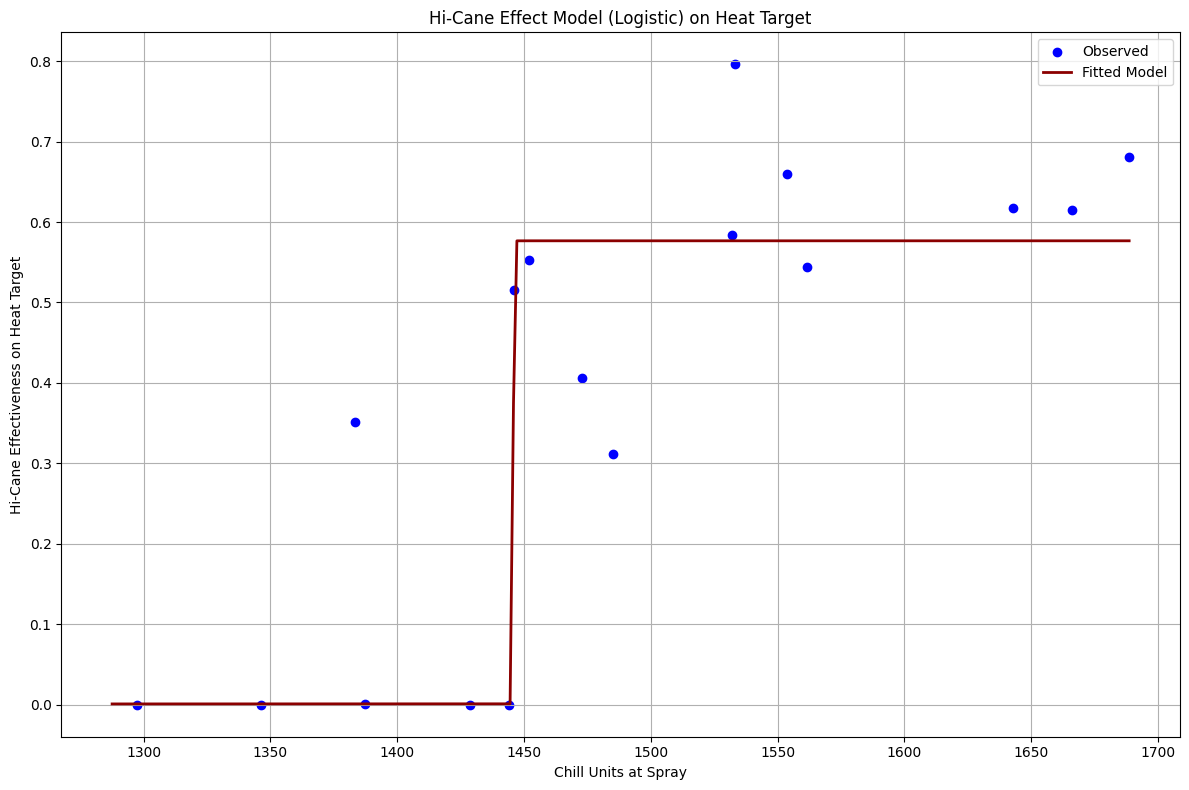

mu: 1445.77
A: 0.58
k: 6.76
e: 0.00


In [32]:
heat_requirement = base_model_config['HeatRequirement']


chu_spray = np.array(chu_spray)
chu_obs = np.array(chu_obs)
control = np.array(control)
spray_doys = np.array(spray_doys)

control_doy = np.array(control_doy)
hc_doy = np.array(hc_doy)

cu_spray = np.array(cu_spray)
cu_obs = np.array(cu_obs)
hu_spray = np.array(hu_spray)
hu_obs = np.array(hu_obs)

filter_endo_spray = (hu_spray < heat_acc_threshold) & (hu_obs <= heat_requirement)


x = cu_spray[filter_endo_spray]
y = hu_obs[filter_endo_spray]/heat_requirement

# Initial guess: [mu, A, k, e]
p0 = [1450, 1, .5, 0]

# Parameter bounds to help constrain and ensure both phases get fit
bounds = (
    [1300, 0, 0, 0],  # Lower bounds
    [1600, 2, 10, 0.001]  # Upper bounds
)

# Fit the model
popt_heat, _ = curve_fit(logistic, x, y, p0=p0, bounds=bounds, maxfev=10000)

# Generate fit curve
x_fit = np.linspace(min(x)-10, max(x), 300)
y_fit = logistic(x_fit, *popt_heat)

# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(x, y, label="Observed", color="blue")
plt.plot(x_fit, y_fit, label="Fitted Model", color="darkred", linewidth=2)
plt.xlabel("Chill Units at Spray")
plt.ylabel("Hi-Cane Effectiveness on Heat Target")
plt.title("Hi-Cane Effect Model (Logistic) on Heat Target")
bbox = dict(boxstyle="round", fc="0.8")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print fitted parameter values
param_names = ["mu", "A", "k", "e"]
for name, val in zip(param_names, popt_heat):
    print(f"{name}: {val:.2f}")



In [28]:
locations = ['Te Puke', 'Kerikeri']
chill_start_day = pd.to_datetime(utils.base_model_config()['StartDay']).day_of_year 


predicted_budbreak_doy = defaultdict(lambda: defaultdict(lambda: defaultdict()))
natural_budbreak_doy = defaultdict(lambda: defaultdict(lambda: defaultdict()))

for i, location in enumerate(locations):
    start_day = int(round(chill_start_day))
    for year, sheet_info in weather_df[location].items(): 
        for sheet_info, weather_data in weather_df[location][year].items():
            weather_since_start_doy = weather_data[weather_data['doy']>=start_day].reset_index(drop=True)  
            
            Acc_cu_spray = CU_spray[location][year][sheet_info]
            Acc_hu_spray = HU_spray[location][year][sheet_info]

            if Acc_hu_spray < heat_acc_threshold and HU_observation[location][year][sheet_info] <= base_model_config['HeatRequirement']:

                proportion_cu = logistic(Acc_cu_spray, *popt_chill)
                effective_chill_target = proportion_cu * base_model_config['ChillRequirement']

                proportion_hu = logistic(Acc_cu_spray, *popt_heat)
                effective_heat_target = proportion_hu * base_model_config['HeatRequirement']

                
                predicted_doy = budbreak_prediction(weather_since_start_doy, effective_chill_target, effective_heat_target)
                predicted_budbreak_doy[location][year][sheet_info] = predicted_doy


def observ_predict_plot(predicted_budbreak_doy, observed_budbreak_doy, HU_spray, HU_observation,  regression_xy=False):
    fig = go.Figure()

    observations = []
    predictions = []
    all_bb_days = []
    for loc in predicted_budbreak_doy.keys():
        for year in predicted_budbreak_doy[loc].keys():
            for sheet_info in predicted_budbreak_doy[loc][year]:

                observed_bb = observed_budbreak_doy[loc][year][sheet_info]
                predicted_bb = predicted_budbreak_doy[loc][year][sheet_info]

                observations.append(observed_bb)
                predictions.append(predicted_bb)

                all_bb_days.append(observed_bb)
                all_bb_days.append(predicted_bb)

                fig.add_trace(go.Scatter(x=[observed_bb], y=[predicted_bb], mode='markers', marker=dict(size=15), name=sheet_info))

    mae = round(utils.mean_absolute_error(observations,predictions),2)
    rmse = round(root_mean_squared_error(observations,predictions),2)


    # Add 1:1 dashed line
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=[min(all_bb_days), max(all_bb_days)], mode='lines', line=dict(color="white", dash="dash"), name="1:1 Line")) 

    # Calculate std of observations to compare with MAE
    obs_std = round(np.std(observations),2)
    # ±MAE bands
    upper_line_mae = np.array([min(all_bb_days), max(all_bb_days)]) + np.array(mae)   
    lower_line_mae = np.array([min(all_bb_days), max(all_bb_days)]) - np.array(mae)  
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=upper_line_mae, mode='lines', line=dict(color="grey", dash="dot"), name='+MAE'))
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=lower_line_mae, mode='lines', line=dict(color="grey", dash="dot"), name='-MAE'))  
    # RMSE bands: If RMSE bands are much wider than MAE bands, it means there are large outliers affecting the model's performance.
    upper_line_rmse = np.array([min(all_bb_days), max(all_bb_days)]) + np.array(mae)   
    lower_line_rmse = np.array([min(all_bb_days), max(all_bb_days)]) - np.array(mae)  
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=upper_line_rmse, mode='lines', line=dict(color="yellow", dash="dot"), name='+RMSE'))
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=lower_line_rmse, mode='lines', line=dict(color="yellow", dash="dot"), name='-RMSE'))  

    # Plot regression line
    if regression_xy is not False:
        fig.add_trace(go.Scatter(x=regression_xy[0], y=regression_xy[1], mode='lines', line=dict(color="white", dash="solid"), name=f"Regression"))

    # Update layout
    fig.update_layout(
        title= f"BudBurst (MAE = {mae}, RMSE = {rmse}, ObsSTD = {obs_std})",
        xaxis_title="Observed BudBurst DOY",
        yaxis_title="Predicted BudBurst DOY",
        template="plotly_dark", width=1600, height=1400)
    fig.show()

observ_predict_plot(predicted_budbreak_doy, observed_budbreak_doy, HU_spray, HU_observation)

            

1000.0 0.0009999999999999998
1047.3684210526317 0.0009999999999999998
1094.7368421052631 0.0009999999999999998
1142.1052631578948 0.0009999999999999998
1189.4736842105262 0.0009999999999999998
1236.842105263158 0.0009999999999999998
1284.2105263157896 0.0009999999999999998
1331.578947368421 0.0009999999999999998
1378.9473684210527 0.0009999999999999998
1426.3157894736842 0.0009999999999999998
1473.6842105263158 0.5766662899004362
1521.0526315789475 0.5766662899004362
1568.421052631579 0.5766662899004362
1615.7894736842104 0.5766662899004362
1663.157894736842 0.5766662899004362
1710.5263157894738 0.5766662899004362
1757.8947368421054 0.5766662899004362
1805.2631578947369 0.5766662899004362
1852.6315789473683 0.5766662899004362
1900.0 0.5766662899004362


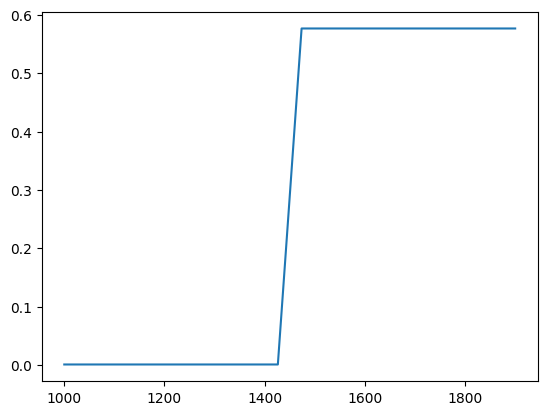

In [750]:
points = np.linspace(1000,1900,20)

outputs = logistic(points, *popt_heat) 

plt.plot(points,outputs)

for p,o in zip(points,outputs):
    print(p,o)